# ICORES 2020

In [1]:
import csv
import json
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

from lime.lime_text import LimeTextExplainer

from ortools.graph import pywrapgraph

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

import math

from sklearn.metrics import precision_recall_fscore_support

from sklearn.externals import joblib

import utils

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/nkanak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nkanak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Data has been retrieved from the publicly accessible Jira instance of the open source projects of Apache Foundation.
# Check this URL: https://issues.apache.org/jira .
with open('hadoop_issues.json') as f:
    issues = json.load(f)
issues = issues['issues']

In [3]:
extra_stopwords = ["a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would"]

In [4]:
# Keep only the issues with assignee (HADOOP project).
issues = [issue for issue in issues if issue['fields'].get('assignee') is not None]

In [5]:
len(issues)

677

In [6]:
# TODO: Modify me!
NUMBER_OF_DEVELOPERS_INCLUDED = 21
most_common = Counter([issue['fields']['assignee']['key'] for issue in issues]).most_common(NUMBER_OF_DEVELOPERS_INCLUDED)
most_common

[('stevel@apache.org', 78),
 ('gabor.bota', 38),
 ('danielzhou', 34),
 ('ajisakaa', 24),
 ('ajayydv', 23),
 ('tasanuma0829', 21),
 ('elek', 18),
 ('mackrorysd', 17),
 ('wujinhu', 14),
 ('bharatviswa', 13),
 ('belugabehr', 11),
 ('xiaochen', 11),
 ('tmarquardt', 11),
 ('giovanni.fumarola', 11),
 ('daryn', 9),
 ('esmanii', 9),
 ('unclegen', 9),
 ('jack-lee', 8),
 ('zvenczel', 8),
 ('zhenyi', 8),
 ('vishwajeet.dusane', 7)]

In [7]:
included_developers = [developer_name for developer_name, _ in most_common]

In [8]:
# Keep only the issues of the 4 most important employees, i.e. employees with the highest number of assigned issues (statistical significance).
issues = [issue for issue in issues if issue['fields']['assignee']['key'] in included_developers]

In [9]:
included_developers

['stevel@apache.org',
 'gabor.bota',
 'danielzhou',
 'ajisakaa',
 'ajayydv',
 'tasanuma0829',
 'elek',
 'mackrorysd',
 'wujinhu',
 'bharatviswa',
 'belugabehr',
 'xiaochen',
 'tmarquardt',
 'giovanni.fumarola',
 'daryn',
 'esmanii',
 'unclegen',
 'jack-lee',
 'zvenczel',
 'zhenyi',
 'vishwajeet.dusane']

In [10]:
len(included_developers)

21

In [11]:
len(issues)

382

In [12]:
unique_assignees_to_number_mapping = {assignee: key for key, assignee in enumerate(list(set(issue['fields']['assignee']['key'] for issue in issues)))}
unique_person_names = sorted([key for key in unique_assignees_to_number_mapping], key=lambda name: unique_assignees_to_number_mapping[name])
print(unique_assignees_to_number_mapping)
utils.pickle_object('pickled_objects/all_issues_unique_person_names.gz', unique_person_names)
utils.pickle_object('pickled_objects/all_issues_class_names.gz', unique_person_names)

{'esmanii': 0, 'daryn': 1, 'tmarquardt': 2, 'unclegen': 3, 'zhenyi': 4, 'zvenczel': 5, 'gabor.bota': 6, 'ajayydv': 7, 'mackrorysd': 8, 'giovanni.fumarola': 9, 'tasanuma0829': 10, 'elek': 11, 'wujinhu': 12, 'ajisakaa': 13, 'belugabehr': 14, 'jack-lee': 15, 'vishwajeet.dusane': 16, 'danielzhou': 17, 'xiaochen': 18, 'bharatviswa': 19, 'stevel@apache.org': 20}


In [13]:
columns = {
    'class': [issue['fields']['assignee']['key'] for issue in issues],
    'text': [(issue['fields']['description'] if issue['fields']['description'] is not None else '') + ' ' + issue['fields']['summary'] for issue in issues],
}

In [14]:
# Compose and clean up text.
# The text of each issue is composed of two attrributes, namely description and summary (see above).
# Removal of english stop words is performed as well as lemmatization and stemming.
# Lemmatization (a Text Normalization technique) is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.
# Stemming is the process of reducing inflected (or sometimes derived) words to their base or root form.
# Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma.
# Stemming is different to Lemmatization in the approach it uses to produce root forms of words and the word produced.
# Also lemmatization and stemming techniques decrease the number of features of each row as far as machine learning is concerned.
for i in range(len(columns['text'])):
    columns['text'][i] = ' '.join([stemmer.stem(wordnet_lemmatizer.lemmatize(word.lower(), pos='v')) for word in columns['text'][i].split() if word.lower() not in stopwords.words('english') + extra_stopwords])

In [15]:
issues_df = pd.DataFrame.from_dict(columns)

In [16]:
issues_df['class'].value_counts()

stevel@apache.org    78
gabor.bota           38
danielzhou           34
ajisakaa             24
ajayydv              23
tasanuma0829         21
elek                 18
mackrorysd           17
wujinhu              14
bharatviswa          13
xiaochen             11
belugabehr           11
giovanni.fumarola    11
tmarquardt           11
unclegen              9
daryn                 9
esmanii               9
zvenczel              8
jack-lee              8
zhenyi                8
vishwajeet.dusane     7
Name: class, dtype: int64

Text(0, 0.5, 'number of issues')

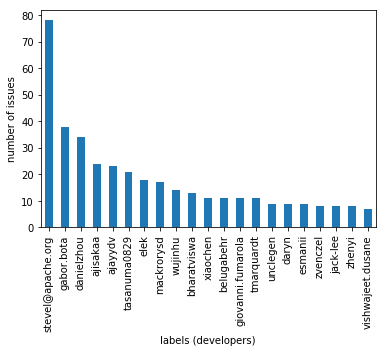

In [17]:
ax = issues_df['class'].value_counts().plot(kind='bar')
ax.set_xlabel('labels (developers)')
ax.set_ylabel('number of issues')

In [18]:
issues_df['class'].value_counts(normalize=True)

stevel@apache.org    0.204188
gabor.bota           0.099476
danielzhou           0.089005
ajisakaa             0.062827
ajayydv              0.060209
tasanuma0829         0.054974
elek                 0.047120
mackrorysd           0.044503
wujinhu              0.036649
bharatviswa          0.034031
xiaochen             0.028796
belugabehr           0.028796
giovanni.fumarola    0.028796
tmarquardt           0.028796
unclegen             0.023560
daryn                0.023560
esmanii              0.023560
zvenczel             0.020942
jack-lee             0.020942
zhenyi               0.020942
vishwajeet.dusane    0.018325
Name: class, dtype: float64

## Example

In [19]:
issues_df['label'] = issues_df['class'].map(unique_assignees_to_number_mapping)
issues_df.to_pickle('pickled_objects/all_issues_df.pickle')

In [20]:
X = issues_df['text']
y = issues_df['label']

# Tokenization, tag/feature generation and removal of frequently occured tags/words.
cv = CountVectorizer(stop_words='english', max_df=0.6)
X_transformed = cv.fit_transform(X)

utils.pickle_object('pickled_objects/all_issues_count_vectorizer.gz', cv)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_transformed, y, range(0, len(issues_df)), test_size=0.33, random_state=42)
print('Train size %s' % X_train.shape[0])
print('Test size %s' % X_test.shape[0])
print('Number of features %s' % X_test.shape[1])

Train size 255
Test size 127
Number of features 4143


In [21]:
def pickle_model(filename, model):
    joblib.dump(model, filename)

# Naive Bayes classifier for multinomial models.
# The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).
# The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
print('Naive bayes #####')
naive_clf = MultinomialNB()
naive_clf.fit(X_train,y_train)
print(naive_clf.score(X_test,y_test))
y_predicted = naive_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/naive_clf.gz', naive_clf)

print('Logistic Regression #####')
logistic_clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
logistic_clf.fit(X_train, y_train)
print(logistic_clf.score(X_test, y_test))
y_predicted = logistic_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/logistic_clf.gz', logistic_clf)

print('SVM ######')
svm_clf = SVC(gamma='auto') 
svm_clf.fit(X_train, y_train)
print(svm_clf.score(X_test, y_test))
y_predicted = svm_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/svm_clf.gz', svm_clf)

print('k-NN #####')
number_of_neighbors = math.ceil(math.log2(len(issues_df)))
print('number of neighbors: %s' % (number_of_neighbors))
knn_clf = KNeighborsClassifier(n_neighbors=number_of_neighbors)
knn_clf.fit(X_train, y_train)
print(knn_clf.score(X_test, y_test))
y_predicted = knn_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/knn_clf.gz', knn_clf)

print('k-NN sqrt #####')
number_of_neighbors = math.ceil(math.sqrt(len(issues_df)))
print('number of neighbors: %s' % (number_of_neighbors))
knn_clf = KNeighborsClassifier(n_neighbors=number_of_neighbors)
knn_clf.fit(X_train, y_train)
print(knn_clf.score(X_test, y_test))
y_predicted = knn_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/knn_clf_sqrt.gz', knn_clf)

print('Neural Network 1000 500 #####')
neural_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(1000, 500), random_state=42)
neural_clf.fit(X_train, y_train)
print(neural_clf.score(X_test, y_test))
y_predicted = neural_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/neural_clf_1000_500.gz', neural_clf)

"""print('Neural Network 2000 1000 #####')
neural_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(2000, 1000), random_state=42)
neural_clf.fit(X_train, y_train)
print(neural_clf.score(X_test, y_test))
y_predicted = neural_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/neural_clf_2000_1000.gz', neural_clf)

print('Neural Network 3000 2000 #####')
neural_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(3000, 2000), random_state=42)
neural_clf.fit(X_train, y_train)
print(neural_clf.score(X_test, y_test))
y_predicted = neural_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/neural_clf_3000_2000.gz', neural_clf)

print('Neural Network 4000 1000 #####')
neural_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(4000, 1000), random_state=42)
neural_clf.fit(X_train, y_train)
print(neural_clf.score(X_test, y_test))
y_predicted = neural_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/neural_clf_4000_1000.gz', neural_clf)
"""

Naive bayes #####
0.4566929133858268
(0.4566929133858268, 0.4566929133858268, 0.4566929133858268, None)
(0.33840869681205815, 0.2843650793650794, 0.2801075435820717, None)
(0.39968514965041135, 0.4566929133858268, 0.39681921664343434, None)
Logistic Regression #####


/home/nkanak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.47244094488188976
(0.47244094488188976, 0.47244094488188976, 0.47244094488188976, None)
(0.4376543209876543, 0.348140589569161, 0.34953366387238055, None)
(0.4752989209682123, 0.47244094488188976, 0.4249928727683172, None)
SVM ######
0.2047244094488189
(0.2047244094488189, 0.2047244094488189, 0.2047244094488189, None)
(0.02841530054644809, 0.05251700680272108, 0.025574139430208174, None)
(0.08281915580224604, 0.2047244094488189, 0.08748530493838647, None)
k-NN #####
number of neighbors: 9
0.18110236220472442
(0.18110236220472442, 0.18110236220472442, 0.18110236220472442, None)
(0.19986309986309986, 0.14520408163265305, 0.11011106717393712, None)
(0.2960758401703284, 0.18110236220472442, 0.170884274200531, None)
k-NN sqrt #####
number of neighbors: 20
0.13385826771653545
(0.13385826771653545, 0.13385826771653545, 0.13385826771653545, None)
(0.1603756818042532, 0.09807256235827663, 0.09066753854646033, None)
(0.2241439414667761, 0.13385826771653545, 0.12894488849722127, None)
Neural Ne

/home/nkanak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nkanak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nkanak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5196850393700787
(0.5196850393700787, 0.5196850393700787, 0.5196850393700787, None)
(0.4579596990311276, 0.3899319727891156, 0.38704009364107894, None)
(0.5788688345774959, 0.5196850393700787, 0.5143186882203988, None)


/home/nkanak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


"print('Neural Network 2000 1000 #####')\nneural_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(2000, 1000), random_state=42)\nneural_clf.fit(X_train, y_train)\nprint(neural_clf.score(X_test, y_test))\ny_predicted = neural_clf.predict(X_test)\nprint(precision_recall_fscore_support(y_test, y_predicted, average='micro'))\nprint(precision_recall_fscore_support(y_test, y_predicted, average='macro'))\nprint(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))\npickle_model('trained_models/neural_clf_2000_1000.gz', neural_clf)\n\nprint('Neural Network 3000 2000 #####')\nneural_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(3000, 2000), random_state=42)\nneural_clf.fit(X_train, y_train)\nprint(neural_clf.score(X_test, y_test))\ny_predicted = neural_clf.predict(X_test)\nprint(precision_recall_fscore_support(y_test, y_predicted, average='micro'))\nprint(precision_recall_fscore_support(y_test, y_predicted, average='macro'))\nprint(precision_recall_fscore_supp

In [22]:
len(cv.vocabulary_)

4143

In [23]:
len(cv.get_feature_names())

4143

In [24]:
len(cv.stop_words_)

0

In [25]:
# arr = X_transformed.toarray()

In [26]:
"""fieldnames = ['assignee', 'word']
with open('word_frequencies_per_assignee.csv', 'w') as f:
    csv_writer = csv.DictWriter(f, fieldnames=fieldnames)
    csv_writer.writeheader()
    for name in unique_person_names:
        x = issues_df[issues_df['class'] == name].index.values.tolist()
        for i in range(arr.shape[1]):
            if arr[x, i].sum() > 0:
                for idx in range(arr[x, i].sum()):
                    csv_writer.writerow({
                        'assignee': name,
                        'word': cv.get_feature_names()[i],
                        #'frequency': arr[x, i].sum(),
                    })
                #print((name, cv.get_feature_names()[i], arr[x, i].sum()))
"""

"fieldnames = ['assignee', 'word']\nwith open('word_frequencies_per_assignee.csv', 'w') as f:\n    csv_writer = csv.DictWriter(f, fieldnames=fieldnames)\n    csv_writer.writeheader()\n    for name in unique_person_names:\n        x = issues_df[issues_df['class'] == name].index.values.tolist()\n        for i in range(arr.shape[1]):\n            if arr[x, i].sum() > 0:\n                for idx in range(arr[x, i].sum()):\n                    csv_writer.writerow({\n                        'assignee': name,\n                        'word': cv.get_feature_names()[i],\n                        #'frequency': arr[x, i].sum(),\n                    })\n                #print((name, cv.get_feature_names()[i], arr[x, i].sum()))\n"

In [27]:
"""fieldnames = ['assignee'] + cv.get_feature_names()
with open('spss_input.csv', 'w') as f:
    csv_writer = csv.DictWriter(f, fieldnames=fieldnames)
    csv_writer.writeheader()
    for i in range(len(issues)):
        d = {}
        d['assignee'] = issues_df['class'][i]
        for (feature, value) in zip(cv.get_feature_names(),X_transformed[i].toarray()[0]):
            d[feature] = value
        csv_writer.writerow(d)
"""

"fieldnames = ['assignee'] + cv.get_feature_names()\nwith open('spss_input.csv', 'w') as f:\n    csv_writer = csv.DictWriter(f, fieldnames=fieldnames)\n    csv_writer.writeheader()\n    for i in range(len(issues)):\n        d = {}\n        d['assignee'] = issues_df['class'][i]\n        for (feature, value) in zip(cv.get_feature_names(),X_transformed[i].toarray()[0]):\n            d[feature] = value\n        csv_writer.writerow(d)\n"

In [28]:
"""with open('spss_input_grouped_by_developer_name.csv', 'w') as f:
    csv_writer = csv.DictWriter(f, fieldnames=fieldnames)
    csv_writer.writeheader()
    d = {}
    for developer in included_developers:
        d[developer] = {
            'assignee': developer
        }
        for feature in cv.get_feature_names():
            d[developer][feature] = 0
            
    for i in range(len(issues)):
        for (feature, value) in zip(cv.get_feature_names(),X_transformed[i].toarray()[0]):
            d[issues_df['class'][i]][feature] += value
    for developer in included_developers:
        csv_writer.writerow(d[developer])
"""

"with open('spss_input_grouped_by_developer_name.csv', 'w') as f:\n    csv_writer = csv.DictWriter(f, fieldnames=fieldnames)\n    csv_writer.writeheader()\n    d = {}\n    for developer in included_developers:\n        d[developer] = {\n            'assignee': developer\n        }\n        for feature in cv.get_feature_names():\n            d[developer][feature] = 0\n            \n    for i in range(len(issues)):\n        for (feature, value) in zip(cv.get_feature_names(),X_transformed[i].toarray()[0]):\n            d[issues_df['class'][i]][feature] += value\n    for developer in included_developers:\n        csv_writer.writerow(d[developer])\n"

In [29]:
# load the model from disk
#loaded_model = joblib.load('trained_models/naive_clf.gz')
#result = loaded_model.score(X_test, y_test)
#print(result)